## Identifying ships in satellite imagery
The data for this work is provided by [rhammell](https://www.kaggle.com/rhammell).

## Kaggle

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [4]:
PATH = "data/ships-in-satellite-imagery/"

For problems using satellite imagery, we need to gether more information on weather the training set just contained certain geographic location, or if it came from geographically scattered area. A model trained on one location will overfit for that location and won't perform well if the test data (or data in production) comes from different area.

The dataset consists of image chips extracted from Planet satellite imagery collected over the San Franciso Bay area.
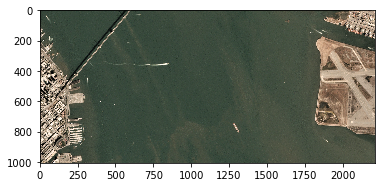
Hence, we can split the dataset into train and validation set randomly.

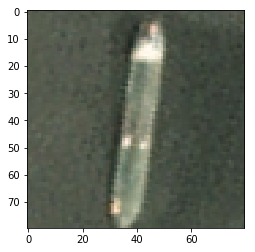

In [5]:
files = !ls {PATH}shipsnet/*.png

img = plt.imread(files[random.randint(0,len(files)-1)])
plt.imshow(img);

## Our first model: quick start

We're going to use a <b>pre-trained</b> model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. We'll be learning all about CNNs during this course.

We will be using the <b>resnet34</b> model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [6]:
# Uncomment the below if you need to reset your precomputed activations
!rm -rf {PATH}tmp

### Data augmentation

Next, to avoid overfitting and increase the performance of the model, we'll augment our imagery by randomly use horizontal flipping, zooming, and rotating.

We can do this by passing `aug_tfms` (*augmentation transforms*) to `tfms_from_model`, with a list of functions to apply that randomly change the image however we wish. For photos that are largely taken from the side (e.g. most photos of dogs and cats, as opposed to photos taken from the top down, such as satellite imagery) we can use the pre-defined list of functions `transforms_side_on`. We can also specify random zooming of images up to specified scale by adding the `max_zoom` parameter.

In [7]:
sz = 80
tfms = tfms_from_model(resnet50, sz, aug_tfms=transforms_top_down, max_zoom=1.1)

In [8]:
def get_augs():
    data = ImageClassifierData.from_csv(PATH, folder='shipsnet', csv_fname=f'{PATH}labels.csv', 
                        tfms=tfms, val_idxs=get_cv_idxs(n=len(open(f'{PATH}labels.csv').readlines())-1), test_name='test')
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

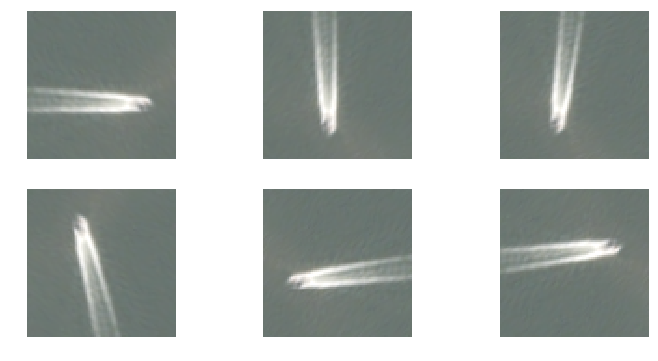

In [9]:
ims = np.stack([get_augs() for i in range(6)])
plots(ims, rows=2)

## Choosing a learning rate

The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [10]:
arch=resnet50
tfms = tfms
data = ImageClassifierData.from_csv(PATH, folder='shipsnet', csv_fname=f'{PATH}labels.csv', 
                        tfms=tfms, val_idxs=get_cv_idxs(n=len(open(f'{PATH}labels.csv').readlines())-1), test_name='test')

learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.1, 3)

100%|██████████| 9/9 [00:00<00:00, 24.87it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.28993  0.09901  0.97991]                     
[ 1.       0.20241  0.06255  0.97768]                       
[ 2.       0.14826  0.05713  0.98214]                       



The *learning rate* determines how quickly or how slowly you want to update the *weights* (or *parameters*). Learning rate is one of the most difficult parameters to set, because it significantly affect model performance.

The method `learn.lr_find()` helps you find an optimal learning rate. It uses the technique developed in the 2015 paper [Cyclical Learning Rates for Training Neural Networks](http://arxiv.org/abs/1506.01186), where we simply keep increasing the learning rate from a very small value, until the loss starts decreasing. We can plot the learning rate across batches to see what this looks like.

We first create a new learner, since we want to know how to set the learning rate for a new (untrained) model.

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[    0.          2.13876  1473.56274     0.52455]         



Our `learn` object contains an attribute `sched` that contains our learning rate scheduler, and has some convenient plotting functionality including this one:

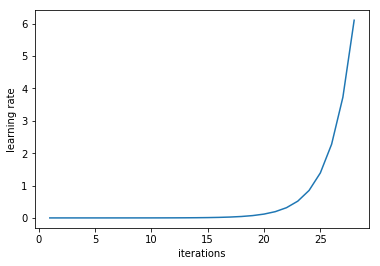

In [13]:
learn.sched.plot_lr()

Note that in the previous plot *iteration* is one iteration (or *minibatch*) of SGD. In one epoch there are 
(num_train_samples/num_iterations) of SGD.

We can see the plot of loss versus learning rate to see where our loss stops decreasing:

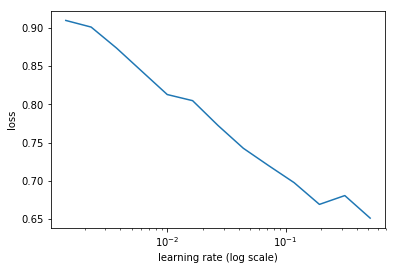

In [14]:
learn.sched.plot()

The loss is still clearly improving at lr=1e-2 (0.01), so that's what we use. Note that the optimal learning rate can change as we training the model, so you may want to re-run this function from time to time.

## Improving our model

In [15]:
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       0.28941  0.10382  0.96429]                      



In [16]:
learn.precompute=False

By default when we create a learner, it sets all but the last layer to *frozen*. That means that it's still only updating the weights in the last layer when we call `fit`.

In [17]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

[ 0.       0.13391  0.09335  0.96875]                      
[ 1.       0.11842  0.07131  0.97991]                      
[ 2.       0.1064   0.0691   0.97321]                      



What is that `cycle_len` parameter? What we've done here is used a technique called *stochastic gradient descent with restarts (SGDR)*, a variant of *learning rate annealing*, which gradually decreases the learning rate as training progresses. This is helpful because as we get closer to the optimal weights, we want to take smaller steps.

However, we may find ourselves in a part of the weight space that isn't very resilient - that is, small changes to the weights may result in big changes to the loss. We want to encourage our model to find parts of the weight space that are both accurate and stable. Therefore, from time to time we increase the learning rate (this is the 'restarts' in 'SGDR'), which will force the model to jump to a different part of the weight space if the current area is "spikey". Here's a picture of how that might look if we reset the learning rates 3 times (in this paper they call it a "cyclic LR schedule"):

<img src="images/sgdr.png" width="80%">
(From the paper [Snapshot Ensembles](https://arxiv.org/abs/1704.00109)).

The number of epochs between resetting the learning rate is set by `cycle_len`, and the number of times this happens is refered to as the *number of cycles*, and is what we're actually passing as the 2nd parameter to `fit()`. So here's what our actual learning rates looked like:

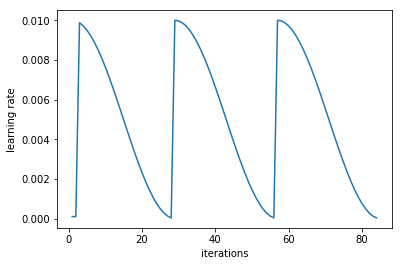

In [18]:
learn.sched.plot_lr()

Our validation loss isn't improving much, so there's probably no point further training the last layer on its own.

Since we've got a pretty good model at this point, we might want to save it so we can load it again later without training it from scratch.

In [19]:
learn.save('80_lastlayer')

In [20]:
learn.load('80_lastlayer')

### Fine-tuning and differential learning rate annealing

Now that we have a good final layer trained, we can try fine-tuning the other layers. 

In [21]:
learn.unfreeze()

Note that the other layers have *already* been trained to recognize imagenet photos (whereas our final layers where randomly initialized), so we want to be careful of not destroying the carefully tuned weights that are already there.

Generally speaking, the earlier layers (as we've seen) have more general-purpose features. Therefore we would expect them to need less fine-tuning for new datasets. For this reason we will use different learning rates for different layers: the first few layers will be at 1e-4, the middle layers at 1e-3, and our FC layers we'll leave at 1e-2 as before. We refer to this as *differential learning rates*, although there's no standard name for this techique in the literature that we're aware of.

In [22]:
lr = 0.1
lr=np.array([lr/18,lr/6,lr/2])

In [23]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

[ 0.       0.1192   0.06091  0.98661]                      
[ 1.       0.09344  0.02667  0.98661]                       
[ 2.       0.06871  0.04315  0.98884]                       
[ 3.       0.05211  0.06643  0.98661]                       
[ 4.       0.04573  0.04371  0.9933 ]                       
[ 5.       0.03396  0.02558  0.9933 ]                       
[ 6.       0.02158  0.02137  0.9933 ]                       



Another trick we've used here is adding the `cycle_mult` parameter. Take a look at the following chart, and see if you can figure out what the parameter is doing:

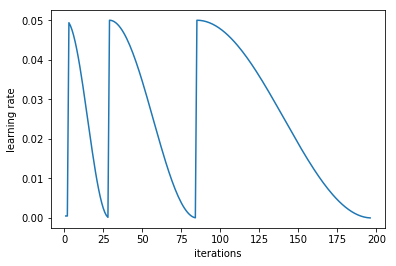

In [24]:
learn.sched.plot_lr()

Note that's what being plotted above is the learning rate of the *final layers*. The learning rates of the earlier layers are fixed at the same multiples of the final layer rates as we initially requested (i.e. the first layers have 100x smaller, and middle layers 10x smaller learning rates, since we set `lr=np.array([1e-4,1e-3,1e-2])`.

In [25]:
learn.save('80_all')

In [26]:
learn.load('80_all')

There is something else we can do with data augmentation: use it at *inference* time (also known as *test* time). Not surprisingly, this is known as *test time augmentation*, or just *TTA*.

TTA simply makes predictions not just on the images in your validation set, but also makes predictions on a number of randomly augmented versions of them too (by default, it uses the original image along with 4 randomly augmented versions). It then takes the average prediction from these images, and uses that. To use TTA on the validation set, we can use the learner's `TTA()` method.

In [27]:
#Accuracy on validation set
log_preds,y = learn.TTA()

accuracy(log_preds,y)

0.9977678571428571

In [28]:
log_preds_test = learn.predict(is_test=True)
log_preds_test.shape

(560, 2)

In [29]:
log_preds_test = np.argmax(log_preds_test, axis=1)
preds_classes = [data.classes[i] for i in log_preds_test]
probs = np.exp(log_preds_test)

In [30]:
df_predictions = pd.DataFrame({'file': os.listdir(f'{PATH}test'), 'class': preds_classes})